# Variational Quantum Circuits as General Function Generators:

A quantum computer and thus quantum circuits follow unitary transformations which allow us to change the state of quantum bits or qubits. The state of a qubit could be anything on the Bloch sphere and thus the most general transformations allow us to create the most general qubit states.

A quantum circuit can also be used as a machine learning model and can be trained according to a given target function. This is possible due to the presence of parameterized gates which are operators whose parameters can be varied. These gates form a circuit which can be repeatedly measured with different values of the parameters to estimate the expectation of some observable. 

Here, we use this property of variational quantum circuits to build General Function Generators. 
In this notebook, we will be building these General Function Generatirs using Fourier Series and the UAT method.


The following work is done with close reference from papers by [ M. Schuld et al](https://arxiv.org/pdf/2008.08605.pdf) [1] and [A. n Pérez-Salinas et al](https://arxiv.org/pdf/2102.04032.pdf) [2]

First, we import the required libraries:

In [1]:
import tequila as tq
import matplotlib.pyplot as plt
import numpy as np

# Method 1: Using Partial Fourier Series:


## Target Function:

The next step is to construct a target function which wil be used to train the parameters of the circuit. We will be using a cosine function for the same as it is one of the most basic and elementary functions.

In [2]:
def target_function(x):
    
    """
    Returns a scaled cosine wave whose values will be used as training points
    
    """
    coef0 = 0.1
    scaling = 1 
    coef = 0.5
    
    return coef0 + coef*np.cos(x*scaling)


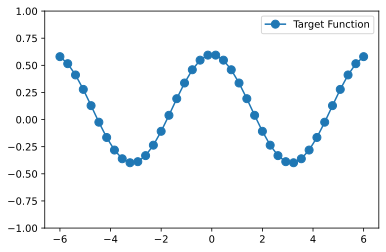

In [3]:
target_x = np.linspace(-6, 6, 40)
target_y = np.array([target_function(_) for _ in target_x])


plt.plot(target_x, target_y, markersize = 8, marker = 'o', label = "Target Function")
plt.legend()
plt.ylim(-1,1)
plt.show()

## Objective Function:

Now, we will construct a variational quantum circuit will be trained to achieve the previously defined target function. Here, we will be using the encoding and trainable circuit blocks specified in the paper M.Schuld et al [1]. 

The encoding block is taken to be an $R_{x}(x)$ rotation gate while the the trainable circuit block consists of a general unitary rotation of the form

$$
W(\vec{\theta}) = R_{z}(a)R_{y}(b)R_{z}(c)
$$

The objective f is thus given by:

$$
f(x) = \langle 0|U^{\dagger}(x,\theta)MU(x,\theta)|0\rangle
$$

Here, M is an observable and $U(x,\theta)$ is given by:

$$
U(x,\theta) = W^{(1)}(\theta)G(x)W^{(2)}(\theta)G(x)W^{(3)}(\theta)...
$$

where $G(x)$ is the data encoding block $R_{x}(x)$

<b>NOTE:</b> In $R_{x}(x)$ the x in the subscript indicates that the rotation is done with respect to the x-axis while the parameter x is the training point.

In [4]:
def rot_variable(a,b,c):
    
    """
    Returns the circuit after the addition of the trainable circuit block
    
    """
    circuit = tq.QCircuit()
    
    circuit += tq.gates.Rz(angle=a, target=0)
    circuit += tq.gates.Ry(angle=b, target=0)
    circuit += tq.gates.Rz(angle=c, target=0)
    return circuit

def objective_function(x, layers, scaling=1.0):
    
    """
    Constructs and returns a trainable tequila objective. The objective is the expectation value E = <U|H|U>
    where H is the Pauli z gate and U is the trainable circuit.
    
    """
    circuit = tq.QCircuit()
    
    for i in range(layers):
        
        a = tq.Variable(name=("a", i))
        b = tq.Variable(name=("b", i))
        c = tq.Variable(name=("c", i))
        
        circuit += rot_variable(a, b, c)
        
        if i != (layers-1):
            circuit += tq.gates.Rx(angle = x*scaling, target = 0) 
            
    H = tq.paulis.Z(0)
    
    E = tq.ExpectationValue(H=H, U = circuit)
    
    return E


## Cost Function:

We now define the cost function whose value will be minimized by the tequila optimizer during the training step.
It is given as

$$
\text{Cost} = \sum{(\text{objective}\_\text{value}(x) - \text{target}\_\text{value}(x))^{2}}
$$

where the summation is taken over all the values of the input variable $x$

In [5]:
def cost(training_points, layers):
    
    """
    Returns the cost of the training problem in the form 
    of a tequila objective.
    
    """
    
    loss = 0.0
    for i in training_points:
        
        loss += (objective_function(i,layers) - target_function(i)).apply(tq.numpy.square)
        
    return loss/len(training_points)



Before training the variational circuit, we need to initialize the trainable parameters with some values which will be the starting point of the optimization problem. Here, we will be providing random initial values to the parameters.

In [6]:
def init_values(layers):
    
    """
    Returns a dictionary of random initial values for all the trainable variables
    
    """
    
    init = {}
    for i in range(layers):
        
        init[('a',i)] = np.random.random() * 2 * np.pi
        init[('b',i)] = np.random.random() * 2 * np.pi
        init[('c',i)] = np.random.random() * 2 * np.pi
        
    return init

## Training:

We will first consider an example with 1 data encoding blocks and 2 trainable circuit blocks i.e. if $W(\theta)$ is the trainable circuit block and $G(x)$ is the data encoding layer, the unitary transformation will be given by:

$$
U = W^{(1)}(\theta)G(x)W^{(2)}(\theta)
$$

We will first generate random values for all the trainable variables and see what the objective function gives us with those values


(-1.0, 1.0)

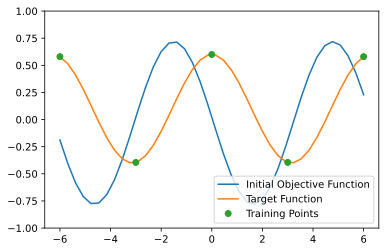

In [8]:
y = []
f = []
x = np.linspace(-6, 6, 5) 
xtest = np.linspace(-6, 6, 40) 

layers = 2
init = init_values(layers)

for i in xtest:
    y.append(tq.simulate(objective_function(i,layers), variables = init))
    f.append(target_function(i))
ftrain = [target_function(i) for i in x]

plt.plot(xtest, y, label = "Initial Objective Function")
plt.plot(xtest, f, label = "Target Function")
plt.plot(x, ftrain, label = "Training Points", marker="o", linestyle="")
plt.legend()
plt.ylim(-1,1)

Here, we can see that the objective function is already in the cosine shape and thus the cosine example is a natural one to see the working of a variational model. We will, now, train the randomly generated values using the tequila optimizer

In [9]:
L = cost(x, layers)
result = tq.minimize(L,initial_values=init)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 5 expectationvalues
gradient        : 90 expectationvalues

active variables : 6

E=+0.25258796  angles= {('a', 0): 5.285814916418635, ('b', 0): 0.9790147277927896, ('c', 0): 2.4918900850531482, ('a', 1): 4.771539552326235, ('b', 1): 4.051787562931569, ('c', 1): 0.8936682753676561}  samples= None
E=+0.12488103  angles= {('a', 0): 5.285814916418635, ('b', 0): 1.6325921216588906, ('c', 0): 2.075700281765745, ('a', 1): 4.550661482110122, ('b', 1): 4.660832319878375, ('c', 1): 0.8936682753676561}  samples= None
E=+0.04632357  angles= {('a', 0): 5.285814916418635, ('b', 0): 1.6824782804071108, ('c', 0): 2.331378114217591, ('a', 1): 4.4855814103184075, ('b', 1): 4.71641506919877, ('c', 1): 0.8936682753676561}  samples= None
E=+0.12172674  angles= {('a', 0): 5.28581

In [10]:
opt_variables = result.variables

(-1.0, 1.0)

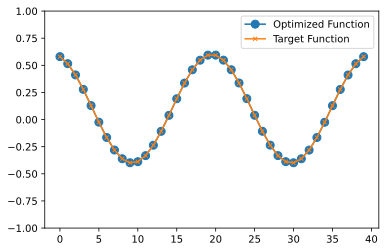

In [11]:
ans = []
target = []
xtest = np.linspace(-6, 6, 40) 
for i in xtest:
    
    f = objective_function(i, layers)
    target.append(target_function(i))
    ans.append(tq.simulate(f,variables=opt_variables))    
    

plt.plot(ans, markersize = 8, marker = 'o', label = "Optimized Function")
plt.plot(target, markersize = 4,marker = 'x', label = "Target Function")
plt.legend()
plt.ylim(-1,1)

Function optimization results:


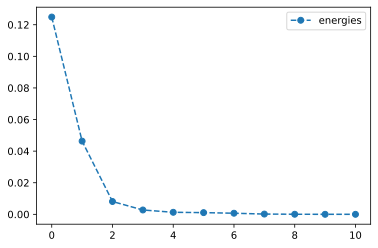

In [12]:
print('Function optimization results:')
result.history.plot('energies')

As we can see, the objective function replicates the target function perfectly. The cost value drops quickly and reaches near 0 in only a couple of iterations.

Now, we will consider a case where we have 4 trainable circuit blocks and 3 data encoding layer i.e. the unitary will be given by:

$$
U = W^{(1)}(\theta)G(x)W^{(2)}(\theta)G(x)W^{(3)}(\theta)G(x)W^{(4)}(\theta)
$$

By taking random values for the trainable variables we get the following values of the objective function

(-1.0, 1.0)

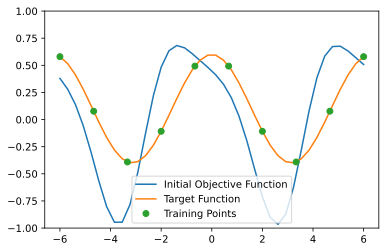

In [13]:
y = []
f = []
x = np.linspace(-6, 6, 10) 
xtest = np.linspace(-6, 6, 40) 

layers = 4
init = init_values(layers)

for i in xtest:
    y.append(tq.simulate(objective_function(i,layers), variables = init))
    f.append(target_function(i))
ftrain = [target_function(i) for i in x]

plt.plot(xtest, y, label = "Initial Objective Function")
plt.plot(xtest, f, label = "Target Function")
plt.plot(x, ftrain, label = "Training Points", marker="o", linestyle="")
plt.legend()
plt.ylim(-1,1)

As we can see, here the frequency has increased as compared to the 2-layer example discussed earlier. Now, if we train these variables using a tequila optimizer we get:

In [14]:
L = cost(x, layers)
result = tq.minimize(L,initial_values=init, silent = True)

In [15]:
opt_variables = result.variables

(-1.0, 1.0)

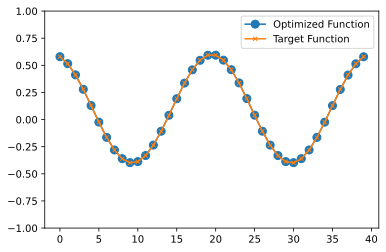

In [16]:
ans = []
target = []
for i in xtest:
    
    f = objective_function(i,layers)
    target.append(target_function(i))
    ans.append(tq.simulate(f,variables=opt_variables))
    
    

plt.plot(ans, markersize = 8, marker = 'o', label = "Optimized Function")
plt.plot(target, markersize = 4,marker = 'x', label = "Target Function")
plt.legend()
plt.ylim(-1,1)

Function optimization results:


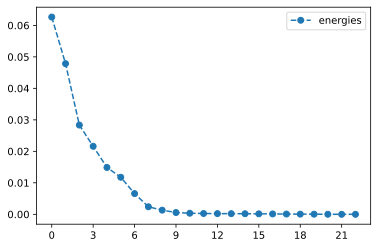

In [17]:
print('Function optimization results:')
result.history.plot('energies')

We can see that the higher frequency objective function was also able to reach the target function after training. But, as we will see in the next example the opposite cannot be done. A higher frequency target function can only be reached by an objective function with the same or higher frequency. 


Here, in the following example we will be modifying our target function and instead of a cosine, we will be using a sawtooth function which is given as follows:

In [18]:
def target_sawtooth(x):
    
    """
    Returns a scaled sawtooth wave whose values will be used as training points
    
    """
    
    an = 0
    bn = [0.6366, -0.3183, 0.2122]
    scaling = 1
    value = an
        
    for i in range(3):
        value = value + bn[i]*np.sin((i+1)*x*scaling)
        
    return value

(-1.0, 1.0)

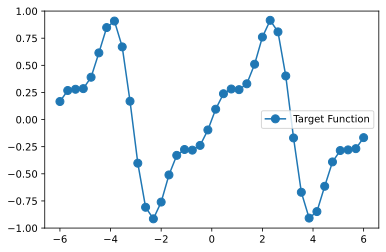

In [19]:
target_x_saw = np.linspace(-6, 6, 40)
target_y_saw = np.array([target_sawtooth(_) for _ in target_x_saw])


plt.plot(target_x_saw, target_y_saw, markersize = 8, marker = 'o', label = "Target Function")
plt.legend()
plt.ylim(-1,1)

We will be using 4 trainable circuit blocks and 3 data encoding blocks to train the sawtooth function. 

If we start with random values for the variables we get the following:

(-1.0, 1.0)

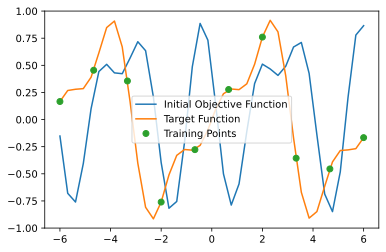

In [21]:
y = []
f = []
x = np.linspace(-6, 6, 10)
xtest = np.linspace(-6, 6, 40) 

layers = 4
init = init_values(layers)

for i in xtest:
    y.append(tq.simulate(objective_function(i,layers), variables = init))
    f.append(target_sawtooth(i))
ftrain = [target_sawtooth(i) for i in x]

plt.plot(xtest, y, label = "Initial Objective Function")
plt.plot(xtest, f, label = "Target Function")
plt.plot(x, ftrain, label = "Training Points", marker="o", linestyle="")
plt.legend()
plt.ylim(-1,1)

In [22]:
def cost_sawtooth(training_points, layers):
    
    """
    Returns the cost of the sawtooth training problem in the form 
    of a tequila objective.
    
    """
    
    loss = 0.0
    for i in training_points:
        
        loss += (objective_function(i,layers) - target_sawtooth(i)).apply(tq.numpy.square)
        
    return loss/len(training_points)

In [23]:
L = cost_sawtooth(x, layers)
result = tq.minimize(L, initial_values=init, silent = True)

In [24]:
opt_variables = result.variables

(-1.0, 1.0)

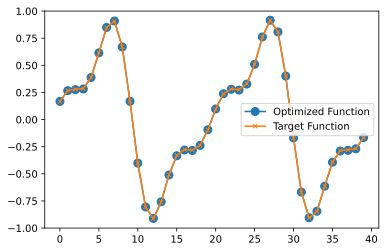

In [25]:
ans = []
target = []
for i in xtest:
    
    f = objective_function(i,layers)
    target.append(target_sawtooth(i))
    ans.append(tq.simulate(f,variables=opt_variables))    
    

plt.plot(ans, markersize = 8, marker = 'o', label = "Optimized Function")
plt.plot(target, markersize = 4,marker = 'x', label = "Target Function")
plt.legend()
plt.ylim(-1,1)

Function optimization results:


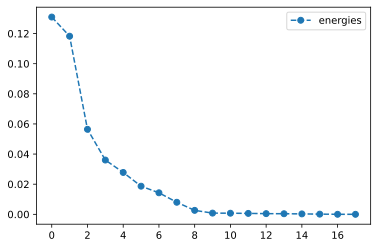

In [26]:
print('Function optimization results:')
result.history.plot('energies')

Here, we can see that the higher dimensional objective function was able to reach the sawtooth function. 


## Coefficients:

Now, we will be checking the expressibility of our fourier series model by checking the range that our fourier coefficients are able to cover. All the trainable blocks and measurement operators contribute to the fourier coefficients. Thus, instead of being arbitrary these coefficients are functions of the degrees of freedom of the qunatum circuit or the objective function constructed above. The coefficients are given as:

$$
c = \sum a_{k, j}
$$

where $a_{k, j}$ is a function of the elements in the trainable block $W(\theta)$ and the observable M. For more details refer [1].

If we consider the first 4 coefficients then their range of values can be demonstrated as:
  


In [27]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2*np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    
    return y

In [28]:
n_coeffs = 4
n_samples = 100

coeffs = []
for i in range(n_samples):

    weights = init_values(5)

    def f(x):
        y = []
        for j in x:
            y.append(tq.simulate(objective_function(j, 5), variables = weights))
        return y

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

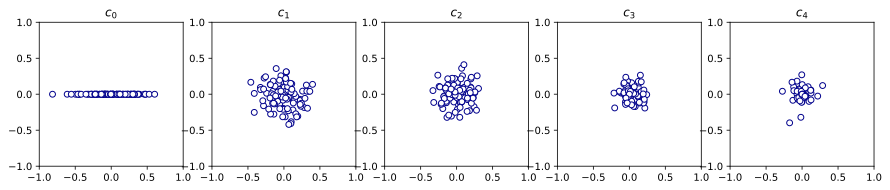

In [29]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15,4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(f"$c_{idx}$")
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=35, facecolor='white', edgecolor='darkblue')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.show()

# Method 2: Using UAT Method:

UAT or Universal Approximation Theorem is a mathematical theorem of artificial neural networks and imply that these networks can converge to a wide variety of functions when given appropriate weights. The accuracy increases with an increase in the number of neural networks layers.

## Target Function:

The target function that we will be using for this method is a tanh(x) function whose shape is similar to that of a sigmoid function.

In [30]:
def target_function_UAT(x):
    
    """
    Returns a tanh(x) wave whose values will be used as training points
    
    """    
    return np.tanh(x)

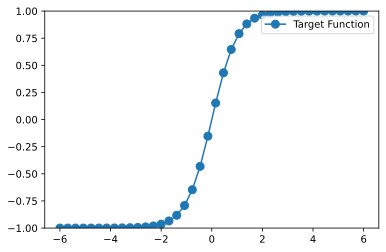

In [31]:
target_x_UAT = np.linspace(-6, 6, 40)
target_y_UAT = np.array([target_function_UAT(_) for _ in target_x_UAT])

plt.plot(target_x_UAT, target_y_UAT, markersize = 8, marker = 'o', label = "Target Function")
plt.legend()
plt.ylim(-1,1)
plt.show()

## Objective Function:

Now, we will construct the variational circuit which will be trained to approximate the target fucntion. The unitary will be constructed with reference to the method specified in the paper by A. Pérez-Salinas et al. [2]

The UAT Unitary is given by:

$$
U^{UAT} = R_{x}(2ax + 2b)R_{y}(2c)
$$

Here, we can see that the $R_{x}$ gate is the data encoding gate while the $R_{y}$ is used to introduce a generalised rotation or an additional trainable parameter. 

In [32]:
def objective_function_UAT(x, layers):
    
    """
    Constructs and returns a trainable tequila objective. The objective is the expectation value E = <U|H|U>
    where H is the Pauli z gate and U is the trainable circuit.
    
    """
    
    circuit = tq.QCircuit()
    
    for i in range(layers):
        
        a = tq.Variable(name=("a", i))
        b = tq.Variable(name=("b", i))
        c = tq.Variable(name=("c", i))
        
        circuit += tq.gates.Rx(angle = 2*a*x + 2*b, target = 0)
        circuit += tq.gates.Ry(angle = 2*c, target = 0)
    
    
    H = tq.paulis.Z(0)
    
    E = tq.ExpectationValue(H=H, U=circuit)
    
    return E  
    
    

## Cost Function:

We will be using a similar cost function and initial values generation block as used in Method 1.


In [33]:
def cost_UAT(training_points, layers):
    
    """
    Returns the cost of the UAT training problem (with l trainable blocks) in the form 
    of a tequila objective.
    
    """
    
    loss = 0.0
    for i in training_points:        
        
        loss += (objective_function_UAT(i,layers) - target_function_UAT(i)).apply(tq.numpy.square)
        
    return loss/len(training_points)
        

In [34]:
def init_values_UAT(layers):
    
    """
    Returns a dictionary of random initial values for all the trainable variables in the UAT method
    
    """
    
    init = {}
    for i in range(layers):
        init[('a',i)] = np.random.random()
        init[('b',i)] = np.random.random()
        init[('c',i)] = np.random.random()
        
    return init

# Training:

For training, first we will consider a 2 layer example. We will first generate random values for all the trainable variables and see what the objective function gives us with those values.

(-1.0, 1.0)

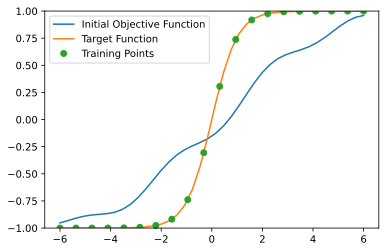

In [45]:
y = []
f = []
x = np.linspace(-6, 6, 20)
xtest = np.linspace(-6, 6, 40)

layers = 2
init = init_values_UAT(layers)
for i in xtest:
    y.append(tq.simulate(objective_function_UAT(i,layers), variables = init))
    f.append(target_function_UAT(i))
ftrain = [target_function_UAT(i) for i in x]

plt.plot(xtest, y, label = "Initial Objective Function")
plt.plot(xtest, f, label = "Target Function")
plt.plot(x, ftrain, label = "Training Points", marker="o", linestyle="")

plt.legend()
plt.ylim(-1,1)

Now we will train the randomly generated values using the tequila optimizer

In [46]:
L = cost_UAT(x, layers)
result = tq.minimize(L, initial_values=init, silent = True)

In [47]:
opt_variables = result.variables

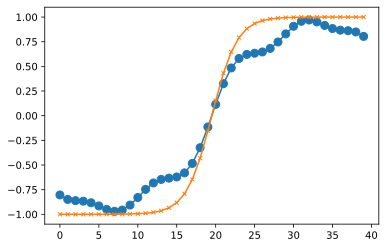

In [48]:
ans = []
target = []
for i in xtest:
    
    f = objective_function_UAT(i, layers)
    target.append(target_function_UAT(i))
    ans.append(tq.simulate(f,variables=opt_variables))    
    

plt.plot(ans, markersize = 8, marker = 'o', label = "Optimized Function")
plt.plot(target, markersize = 4,marker = 'x', label = "Target Function")


Function optimization results:


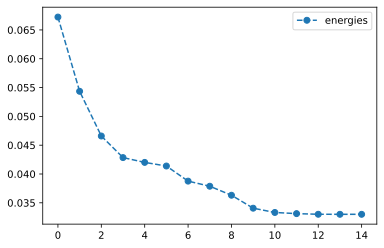

In [49]:
print('Function optimization results:')
result.history.plot('energies')

As we can see here, the objective function is close to the target function.

Now, we will see how the results change if we use 4 layers instead of 2. First, we will take some random values for the trainable variables

(-1.0, 1.0)

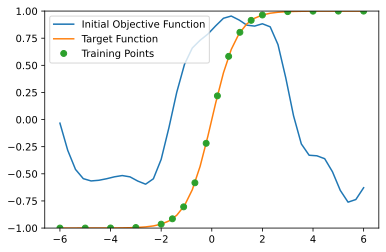

In [87]:
y = []
f = []
x = np.asarray([-6,-5,-4,-3] + list(np.linspace(-2, 2, 10)) + [3,4,5,6])

xtest = np.linspace(-6, 6, 40)

layers = 4
init = init_values_UAT(layers)
for i in xtest:
    y.append(tq.simulate(objective_function_UAT(i,layers), variables = init))
    f.append(target_function_UAT(i))
ftrain = [target_function_UAT(i) for i in x]

plt.plot(xtest, y, label = "Initial Objective Function")
plt.plot(xtest, f, label = "Target Function")
plt.plot(x, ftrain, label = "Training Points", marker="o", linestyle="")

plt.legend()
plt.ylim(-1,1)

Now we will train the randomly generated values using the tequila optimizer

In [88]:
L = cost_UAT(x, layers=4)
result = tq.minimize(L, initial_values=init, silent = True)

In [89]:
opt_variables = result.variables

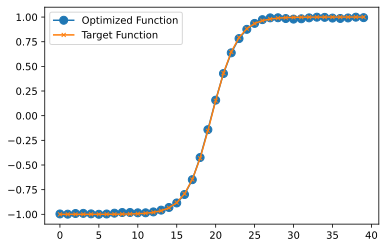

In [90]:
ans = []
target = []
for i in xtest:
    
    f = objective_function_UAT(i, layers)
    target.append(target_function_UAT(i))
    ans.append(tq.simulate(f,variables=opt_variables))
        

plt.plot(ans, markersize = 8, marker = 'o', label = "Optimized Function")
plt.plot(target, markersize = 4,marker = 'x', label = "Target Function")
plt.legend()

Function optimization results:


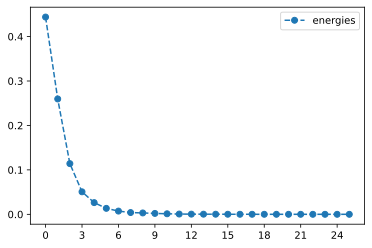

In [91]:
print('Function optimization results:')
result.history.plot('energies')

We can see, that the result with 4 layers is significantly better than the one obtained with 2 layers. The final plot also verifies that more number of layers result in a higher accuracy.

<b>NOTE:</b> The results will vary due to the random initialization of the trainable parameters and the choice of the optimizer/threshold values. For more information about the workings of the tequila optimizer kindly refer to the [optimizer tutorial](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/Optimizer_Tutorial.ipynb) which covers the usage of different optimizers available in tequila.

In some places, random optimization will become a problem, at least with respect to gradient based optimization which is used in this tutorial. For more details about the potential issues refer [this](https://www.nature.com/articles/s41467-018-07090-4) paper that talks about barren plateaus. 

One could adopt better initialization strategies(for example: by studying simpler models which approximates the given model and extending the solution) or increase the depth of the variation circuit (refer [this](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.023203)) to overcome any potential issues.



# References:

[1] Maria Schuld, Ryan Sweke, and Johannes Jakob Meye, " The effect of data encoding on the expressive power of variational quantum machine learning models ". <br>
[2] Adri$\acute{\text{a}}$n P$\acute{\text{e}}$rez-Salinas ,David L$\acute{\text{o}}$pez-N$\acute{\text{u}}$$\tilde{\text{n}}$ez, Artur Garc$\acute{\text{i}}$a-S$\acute{\text{a}}$ez, P. Forn-D$\acute{\text{i}}$az, and Jos$\acute{\text{e}}$ I. Latorre, "One qubit as a Universal Approximant".
